In [1]:
!pip install prophet openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [23]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [24]:
# File must have two columns: ds (date), y (daily signups)
df = pd.read_csv("MyneSignups.csv")
df['ds'] = pd.to_datetime(df['ds'])  # Ensure date format
df.head()


,ds,y
0,2025-06-01,6
1,2025-06-02,4
2,2025-06-03,11
3,2025-06-04,9
4,2025-06-05,12


In [31]:
model = Prophet()
model.fit(df)

#Forecast next 23 days (up to end of July)
future = model.make_future_dataframe(periods=40) # days
forecast = model.predict(future)


17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Prophet cumulative forecast
forecast["cumulative_yhat"] = forecast["yhat"].fillna(0).cumsum()

C:\Users\Sehar Irfan\AppData\Local\Temp\ipykernel_15192\685968212.py:11: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


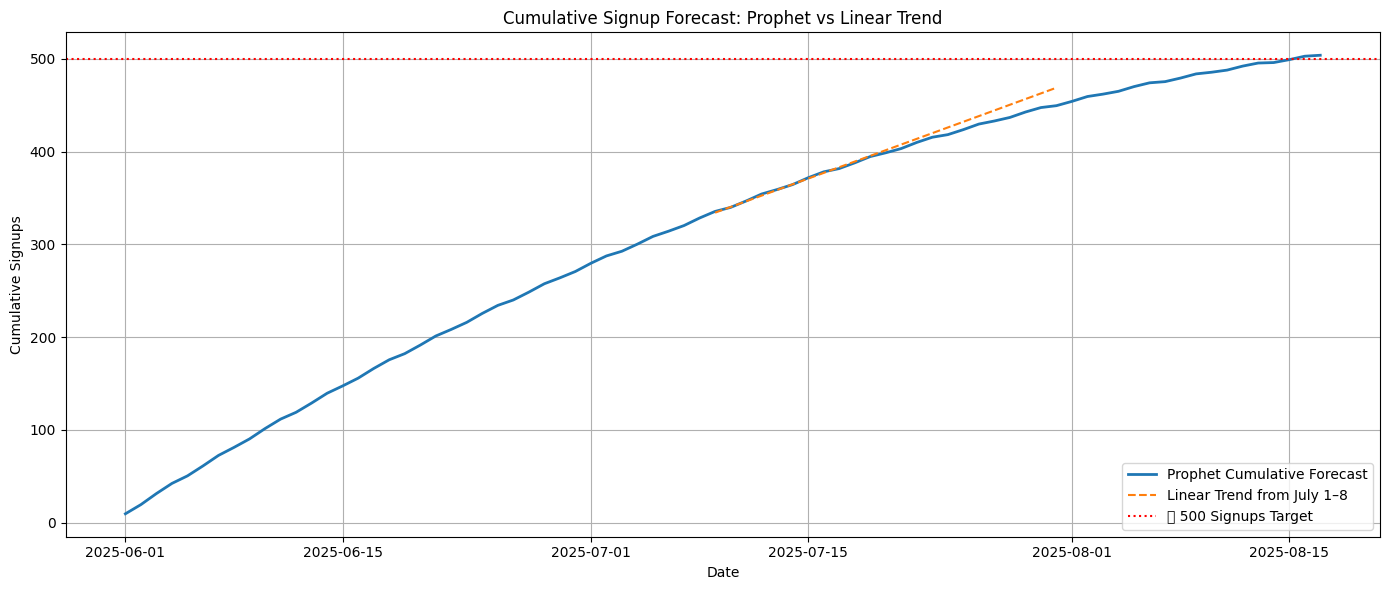

In [33]:
# STEP 7: Plot overlay
plt.figure(figsize=(14, 6))
plt.plot(forecast["ds"], forecast["cumulative_yhat"], label="Prophet Cumulative Forecast", linewidth=2)
plt.plot(linear_df["ds"], linear_df["Linear Cumulative Signups"], label="Linear Trend from July 1–8", linestyle='--')
plt.axhline(y=500, color='red', linestyle=':', label="🎯 500 Signups Target")
plt.title("Cumulative Signup Forecast: Prophet vs Linear Trend")
plt.xlabel("Date")
plt.ylabel("Cumulative Signups")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

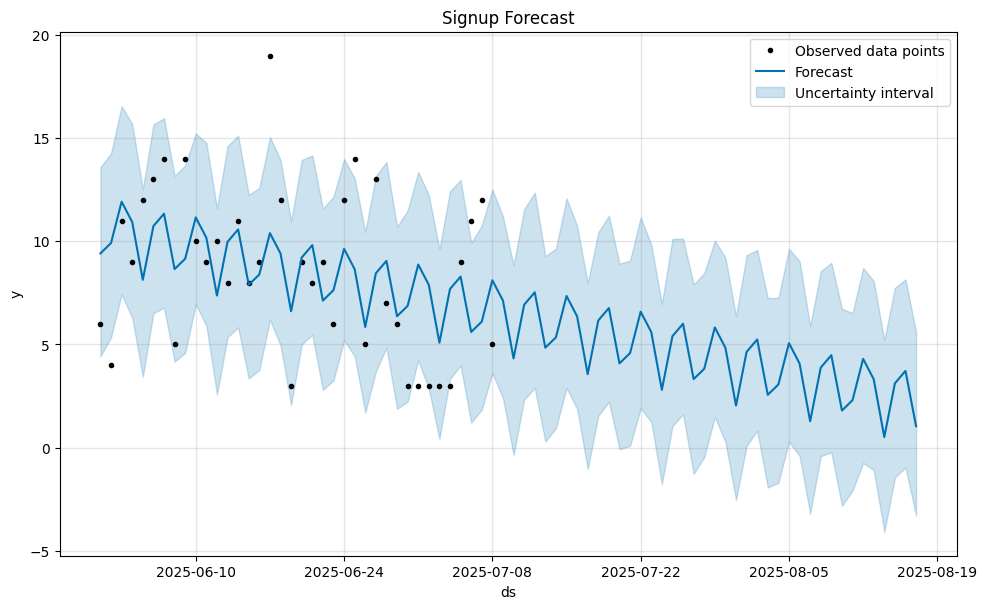

In [34]:
#Plot the forecast
fig = model.plot(forecast)
plt.title("Signup Forecast")
plt.legend()
plt.show()

# STEP 7: Save forecast to CSV and Excel
#output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
#output.to_csv("signup_forecast.csv", index=False)
#print("Forecast saved as 'signup_forecast.csv")


# Linear Projection Model

In [27]:
import pandas as pd

# Assume df is already defined and contains your data with 'ds' and 'y' columns
#Linear projection model
# Filter July 1–8 data
july_data = df[(df["ds"] >= "2025-07-01") & (df["ds"] <= "2025-07-08")]
daily_avg = july_data["y"].mean()

# Current cumulative signups as of July 8
cumulative_start = df[df["ds"] <= "2025-07-08"]["y"].sum()

# Forecast daily cumulative signups until end of July or until 500 is reached
days = 0
forecasted_signups = cumulative_start
forecast_rows = []

while forecasted_signups < 500:
    days += 1
    forecasted_signups += daily_avg
    forecast_date = pd.to_datetime("2025-07-08") + pd.Timedelta(days=days)
    forecast_rows.append({"ds": forecast_date, "Projected Cumulative Signups": forecasted_signups})

# Create DataFrame
forecast_df = pd.DataFrame(forecast_rows)

# Print forecast and the target date
print(forecast_df)
if not forecast_df.empty:
    target_date = forecast_df[forecast_df["Projected Cumulative Signups"] >= 500].iloc[0]["ds"]
    print(f"\n Expected to reach 500 signups by: {target_date.strftime('%Y-%m-%d')}")
else:
    print("500 signups cannot be reached within the projection range.")


           ds  Projected Cumulative Signups
0  2025-07-09                       334.125
1  2025-07-10                       340.250
2  2025-07-11                       346.375
3  2025-07-12                       352.500
4  2025-07-13                       358.625
5  2025-07-14                       364.750
6  2025-07-15                       370.875
7  2025-07-16                       377.000
8  2025-07-17                       383.125
9  2025-07-18                       389.250
10 2025-07-19                       395.375
11 2025-07-20                       401.500
12 2025-07-21                       407.625
13 2025-07-22                       413.750
14 2025-07-23                       419.875
15 2025-07-24                       426.000
16 2025-07-25                       432.125
17 2025-07-26                       438.250
18 2025-07-27                       444.375
19 2025-07-28                       450.500
20 2025-07-29                       456.625
21 2025-07-30                   

# Forecasting Budget vs Signups

In [37]:
#djust these values to simulate different scenarios
model_result = signup_forecast_model(
    budget=18350,          # Total available budget
    cps_android=9.5,       # Cost per signup on Android
    cps_ios=12.0,          # Cost per signup on iOS
    android_share=0.7,     # % of budget allocated to Android
    signup_goal=500        # Target signups
)

model_result

,Current Budget (AED),Signup Goal,CPS Android,CPS iOS,Android Share,iOS Share,Predicted Android Signups,Predicted iOS Signups,Total Predicted Signups,Required Budget for Goal (AED),Budget Surplus or Deficit (AED)
0,18350,500,9.5,12.0,0.7,0.3,1352,459,1811,5125,13225


In [36]:
#Signup Forecasting Model
#helps forecast how many signups you can get based on your budget, cost per signup (CPS), and Android/iOS budget split.

# Define the forecasting function
def signup_forecast_model(budget, cps_android, cps_ios, android_share, signup_goal):
    ios_share = 1 - android_share
    android_budget = budget * android_share
    ios_budget = budget * ios_share

    # Forecasted signups based on budget allocation
    signups_android = android_budget / cps_android
    signups_ios = ios_budget / cps_ios
    total_predicted_signups = signups_android + signups_ios

    # Required budget to meet signup goal
    required_android_signups = signup_goal * android_share
    required_ios_signups = signup_goal * ios_share
    required_budget_android = required_android_signups * cps_android
    required_budget_ios = required_ios_signups * cps_ios
    total_required_budget = required_budget_android + required_budget_ios

    # Compile results
    result = {
        "Current Budget (AED)": budget,
        "Signup Goal": signup_goal,
        "CPS Android": cps_android,
        "CPS iOS": cps_ios,
        "Android Share": android_share,
        "iOS Share": ios_share,
        "Predicted Android Signups": round(signups_android),
        "Predicted iOS Signups": round(signups_ios),
        "Total Predicted Signups": round(total_predicted_signups),
        "Required Budget for Goal (AED)": round(total_required_budget),
        "Budget Surplus or Deficit (AED)": round(budget - total_required_budget)
    }

    return pd.DataFrame([result])